<a href="https://colab.research.google.com/github/benjamin-dinh/tuberculosis-drug-resistance/blob/main/tuberculosis_drug_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tuberculosis Drug Resistance**

Team: McKenzie Hochbery, Melissa Jost, Mohammad Ismail Daud, Taimur Kashif, Benjamin Dinh

We built four models to determine thresholds for high and low data signals. We looked at whether certain molecular probes designed to detect specific gene mutations yield high or low signals. Early detection of drug resistance can quicken the process of finding the right drug cocktail to treat TB.

Our four models were:
- Z-Scores
- Decision Trees
- Neural Networks
- Logistic Regression

Result: Decision Trees yielded the highest accuract rate of 98%.

## *Preprocessing*
---



In [ ]:
import pandas as pd

!pip install styleframe
from styleframe import StyleFrame, utils
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
uploaded = files.upload() # cleared excel sheet of unnecessary rows/columns before upload

Saving mdr_tb_data.xlsx to mdr_tb_data.xlsx


In [ ]:
# store each value in dataframe as an object
class Data:
  def __init__(self, value, expressed):
    self.value = value # value in data table
    self.expressed = expressed # boolean to represent if the signal is expressed

In [ ]:
# transfer entire excel sheet into data frame
sf = StyleFrame.read_excel('mdr_tb_data.xlsx', read_style=True)

#iterate through data to note which samples are expressed or not
for row in range(0, 336):
    for col in range(0, 43):
        col_name = sf.data_df.columns[col]
        cell_val = sf.data_df.iloc[row, col].value
        if sf.iloc[row, col].style.bg_color in {utils.colors.black, '00000000'}:
            x = False # white background data cell
        else:
            x = True # non-white background data cell
        result = Data(cell_val, x)
        # sf.iloc[row, col].value = result # store object back into data frame
        sf.iloc[row, col].value = [cell_val, x]     # use this line to visually look at values in data frame

# remove last duplicate row to clean data
sf.data_df = sf.data_df.drop(sf.data_df.index[[336]])

# display dataframe stored within styleframe
sf.data_df

,Sample ID,132 katG 315 Ser 8/10/09,133 katG 315 Thr 8/10/09,102 katG 315 Arg 3/25/09,104 katG 315 ile 10/19/09,105 katG 315 Gly 10/19/09,106 katG 315 Asn 3/25/09,315 katG Thr 5/2009 (2),143 inhA -15C 11/1/11,145 inhA -15T 11/1/11,162 rpoB 516 Asp 6//6/11,115 rpoB 516 Tyr 11/10/11,118 rpoB 516 Val 6/15/09,121 rpoB 516 Glu 8/18/11,169 rpoB 516 Gly 9/2/11,515 and 516 ATC rpoB (28),515 and 516 rpoB ATT (58),88 rpoB 526 His 21 bp 4/4/18,103 rpoB 526 Asp 8/18/11,135 rpoB 526 Tyr 11/10/11,108 rpoB 526 Arg 8/18/11,164 rpoB 526 Leu 6/1/11,168 rpoB 526 Cys 9/2/11,181 rpoB 526 Pro 11/9/11,188 rpoB 531 ser WT 9/2/11,110 rpoB Cys 531 11/10/11,130 rpoB 531 Trp 11/14/11,136 rpoB 531 Leu 8/18/11,166 rpsL 43 Wt 8/18/11,167 rpsL 43 8/18/11,134 rpsL 88 11/14/2011,127 rpsL 88 11/14/2011,175 rrs 513A 1/23/12,146 rrs 513C 2/6/2012,148 rrs 516C WT 10/15/2012,161 rrs 516T 10/30/2012,140 embB 306 WT 10/15/2012,157 embB 306 Val 10/30/2012,306 emB Iso ATC 5-16-13 (77),126 306 embB ATA (26),306 emB ATT 11-25-13 (78),150 IS6110 9/2011,Unnamed: 42,Unnamed: 43
0,"['474/12', False]","[209.0, False]","[3124.0, True]","[125.0, False]","[178.0, False]","[145.5, False]","[299.5, False]","[147.0, False]","[7989.5, True]","[1219.0, False]","[138.0, False]","[79.0, False]","[200.0, False]","[138.0, False]","[140.5, False]","[147.0, False]","[1153.0, True]","[6356.0, True]","[172.0, False]","[247.0, False]","[250.0, False]","[504.0, False]","[143.0, False]","[231.5, False]","[2050.5, True]","[122.0, False]","[277.0, False]","[442.0, False]","[5880.0, True]","[190.0, False]","[7318.0, True]","[280.0, False]","[3903.5, True]","[160.0, False]","[5595.0, True]","[320.5, False]","[674.0, False]","[159.0, False]","[3387.0, True]","[1424.0, False]","[263.0, False]","[6389.5, False]","[nan, False]",nan
1,"['↓', False]","[207.5, False]","[3176.0, True]","[125.0, False]","[167.5, False]","[108.0, False]","[266.0, False]","[147.0, False]","[7916.0, True]","[1268.0, False]","[173.0, False]","[124.0, False]","[135.5, False]","[131.0, False]","[132.0, False]","[103.5, False]","[1086.5, True]","[6493.0, True]","[210.5, False]","[228.0, False]","[266.0, False]","[533.0, False]","[108.0, False]","[241.0, False]","[2131.0, True]","[142.0, False]","[292.5, False]","[445.5, False]","[5941.0, True]","[180.0, False]","[7596.0, True]","[277.0, False]","[3889.5, True]","[143.0, False]","[5516.0, True]","[318.0, False]","[730.5, False]","[116.5, False]","[3455.0, True]","[1414.0, False]","[263.0, False]","[6689.0, False]","[nan, False]",nan
2,"['497/12', False]","[182.0, False]","[3205.0, True]","[138.0, False]","[180.0, False]","[114.0, False]","[296.0, False]","[147.0, False]","[6660.0, True]","[880.0, False]","[1981.0, True]","[134.5, False]","[229.5, False]","[322.5, False]","[418.0, False]","[112.0, False]","[117.0, False]","[6857.5, True]","[454.0, False]","[466.0, False]","[497.5, False]","[1025.0, False]","[160.5, False]","[408.0, False]","[186.0, False]","[195.0, False]","[896.0, False]","[5245.0, True]","[218.0, False]","[3898.0, True]","[8077.5, True]","[299.5, False]","[4720.0, True]","[159.0, False]","[7942.0, True]","[331.0, False]","[551.5, False]","[3666.0, True]","[130.0, False]","[97.0, False]","[263.0, False]","[6220.0, False]","[nan, False]",nan
3,"['↓', False]","[199.5, False]","[3298.5, True]","[122.5, False]","[180.0, False]","[146.0, False]","[298.0, False]","[147.0, False]","[6961.0, True]","[903.0, False]","[1961.0, True]","[158.0, False]","[211.5, False]","[312.0, False]","[377.0, False]","[112.0, False]","[117.0, False]","[7240.0, True]","[475.5, False]","[500.0, False]","[528.5, False]","[1107.5, False]","[178.0, False]","[443.0, False]","[247.0, False]","[192.0, False]","[961.0, False]","[5532.5, True]","[198.0, False]","[4016.5, True]","[8208.0, True]","[315.0, False]","[5066.0, True]","[185.0, False]","[8294.0, True]","[392.5, False]","[586.0, False]","[3681.5, True]","[131.0, False]","[66.0, False]","[263.0, False]","[6328.0, False]","[nan, False]",nan
4,"[

In [ ]:
# Isoniazid data frame
idf_c = sf.data_df[[" Sample ID", "132 katG 315 Ser 8/10/09", "133 katG 315 Thr 8/10/09", "102 katG 315 Arg 3/25/09", "104 katG 315 ile 10/19/09", "105 katG 315 Gly 10/19/09", "106 katG 315 Asn 3/25/09", "315 katG Thr 5/2009 (2)","143 inhA -15C 11/1/11", "145 inhA -15T 11/1/11"]]
idf = idf_c.copy()

# Rifampicin data frame
rdf_c = sf.data_df[[" Sample ID", "162 rpoB 516 Asp 6//6/11", "115 rpoB 516 Tyr 11/10/11", "118 rpoB 516 Val 6/15/09", "121 rpoB 516 Glu 8/18/11", "169 rpoB 516 Gly 9/2/11", "515 and 516 ATC rpoB (28)", "515 and 516 rpoB ATT (58)","88 rpoB 526 His 21 bp 4/4/18", "103 rpoB 526 Asp 8/18/11", "135 rpoB 526 Tyr 11/10/11", "108 rpoB 526 Arg 8/18/11", "164 rpoB 526 Leu 6/1/11", "168 rpoB 526 Cys 9/2/11", "181 rpoB 526 Pro 11/9/11","188 rpoB 531 ser WT 9/2/11", "110 rpoB Cys  531 11/10/11", "130 rpoB 531 Trp 11/14/11", "136 rpoB 531 Leu 8/18/11"]]
rdf = rdf_c.copy()

# Streptomycin data frame
sdf_c = sf.data_df[[" Sample ID", "166 rpsL 43 Wt 8/18/11", "167 rpsL 43 8/18/11", "134 rpsL 88 11/14/2011", "127 rpsL 88 11/14/2011", "175 rrs 513A 1/23/12", "146 rrs 513C 2/6/2012", "148 rrs 516C WT 10/15/2012", "161 rrs 516T 10/30/2012"]]
sdf = sdf_c.copy()

# Ethambutol data frame
edf_c = sf.data_df[[" Sample ID", "140 embB 306 WT 10/15/2012", "157 embB 306 Val 10/30/2012", "306 emB Iso ATC 5-16-13 (77)", "126 306 embB ATA (26)", "306 emB ATT 11-25-13 (78)"]]
edf = edf_c.copy()

edf

,Sample ID,140 embB 306 WT 10/15/2012,157 embB 306 Val 10/30/2012,306 emB Iso ATC 5-16-13 (77),126 306 embB ATA (26),306 emB ATT 11-25-13 (78)
0,"['474/12', False]","[674.0, False]","[159.0, False]","[3387.0, True]","[1424.0, False]","[263.0, False]"
1,"['↓', False]","[730.5, False]","[116.5, False]","[3455.0, True]","[1414.0, False]","[263.0, False]"
2,"['497/12', False]","[551.5, False]","[3666.0, True]","[130.0, False]","[97.0, False]","[263.0, False]"
3,"['↓', False]","[586.0, False]","[3681.5, True]","[131.0, False]","[66.0, False]","[263.0, False]"
4,"['539/12', False]","[528.5, False]","[4510.0, True]","[94.0, False]","[88.5, False]","[263.0, False]"
...,...,...,...,...,...,...
331,"[nan, False]","[231.0, False]","[2071.0, True]","[80.5, False]","[103.0, False]","[91.0, False]"
332,"['MDR 54/16 cul', False]","[293.0, False]","[2044.0, True]","[90.0, False]","[96.0, False]","[103.5, False]"
333,"[nan, False]","[249.0, False]","[2166.0, True]","[64.0, False]","[128.0, False]","[116.0, False]"
334,"['MDR 73/16 cul', False]","[338.0, False]","[159.5, False]","[1490.0, True]","[520.0, False]","[253.0, False]"


## *EDA*
---

In [ ]:
def change_dtype(value):
    try:
        return float(value.value[0])
    except:
        return float(value)

def trim(value):
  for i in value.columns:
    value.loc[:, i] = value[i].apply(change_dtype)
  return value


trimmed_idf = idf.copy()
trimmed_idf = trimmed_idf.drop(columns=[' Sample ID'])
trimmed_idf = trim(trimmed_idf)

trimmed_rdf = rdf.copy()
trimmed_rdf = trimmed_rdf.drop(columns=[' Sample ID'])
trimmed_rdf = trim(trimmed_rdf)

trimmed_sdf = sdf.copy()
trimmed_sdf = trimmed_sdf.drop(columns=[' Sample ID'])
trimmed_sdf = trim(trimmed_sdf)

trimmed_edf = edf.copy()
trimmed_edf = trimmed_edf.drop(columns=[' Sample ID'])
trimmed_edf = trim(trimmed_edf)

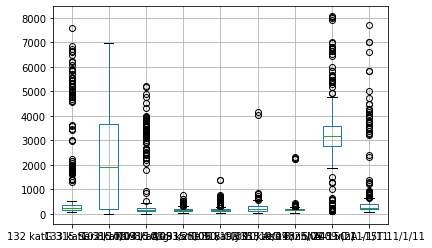

In [ ]:
trimmed_idf.boxplot()

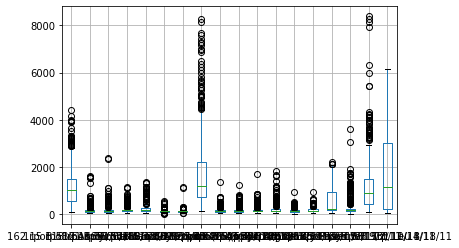

In [ ]:
trimmed_rdf.boxplot()

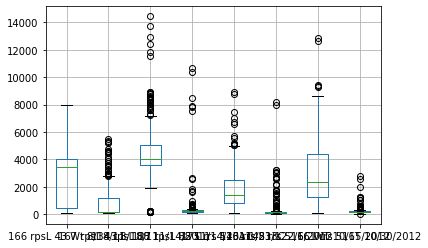

In [ ]:
trimmed_sdf.boxplot()

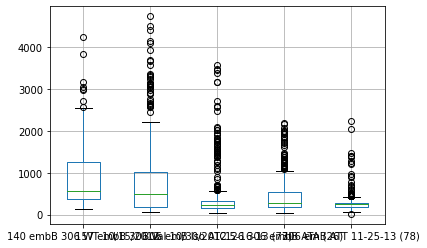

In [ ]:
trimmed_edf.boxplot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning:To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f422f0d7ac8>,
      dtype=object)

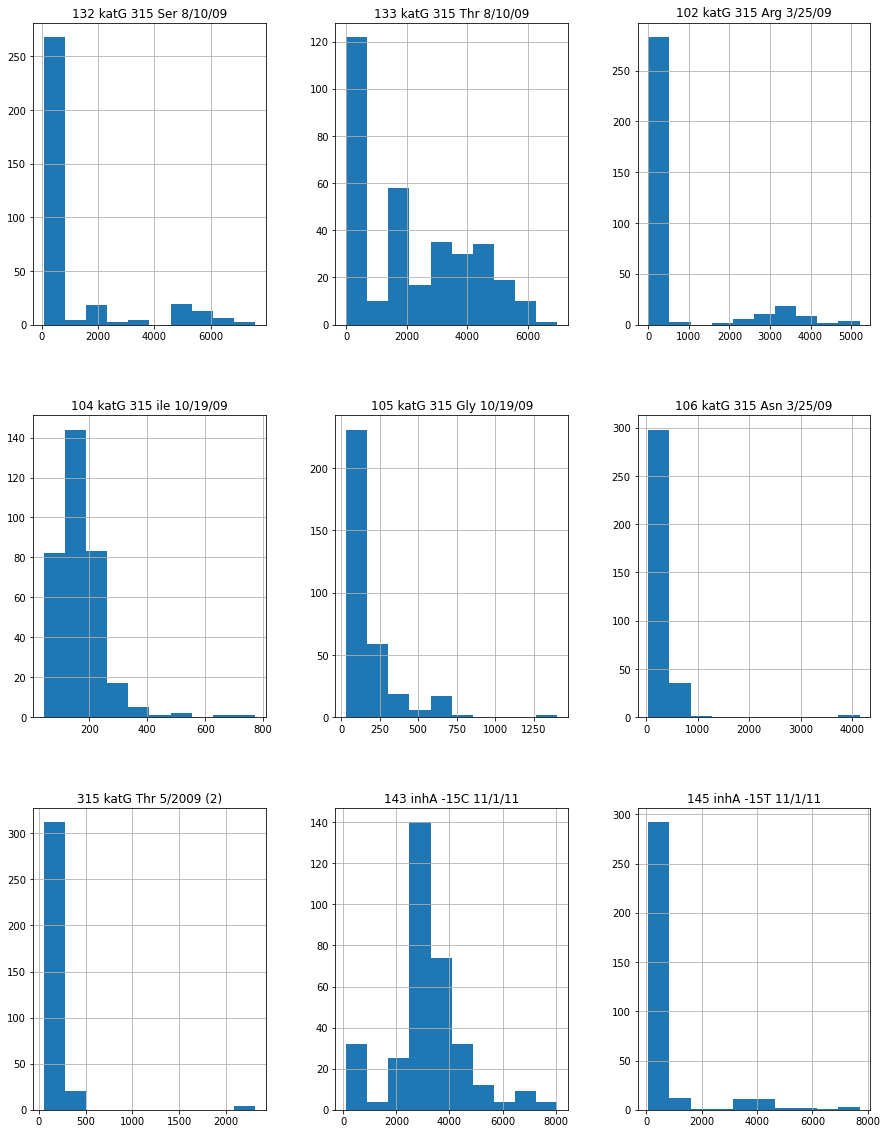

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
trimmed_idf.hist(ax=ax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd14633cc88>,
      dtype=object)

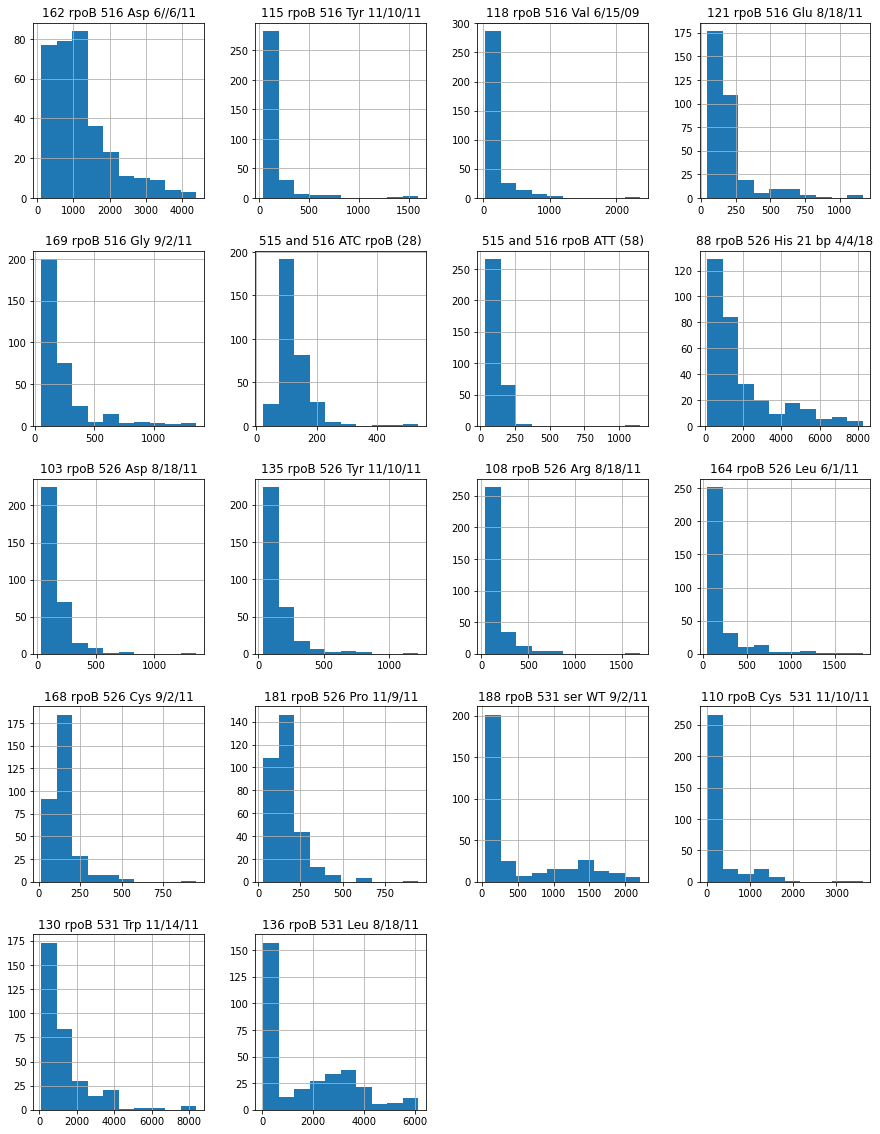

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
trimmed_rdf.hist(ax=ax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd145b844a8>,
      dtype=object)

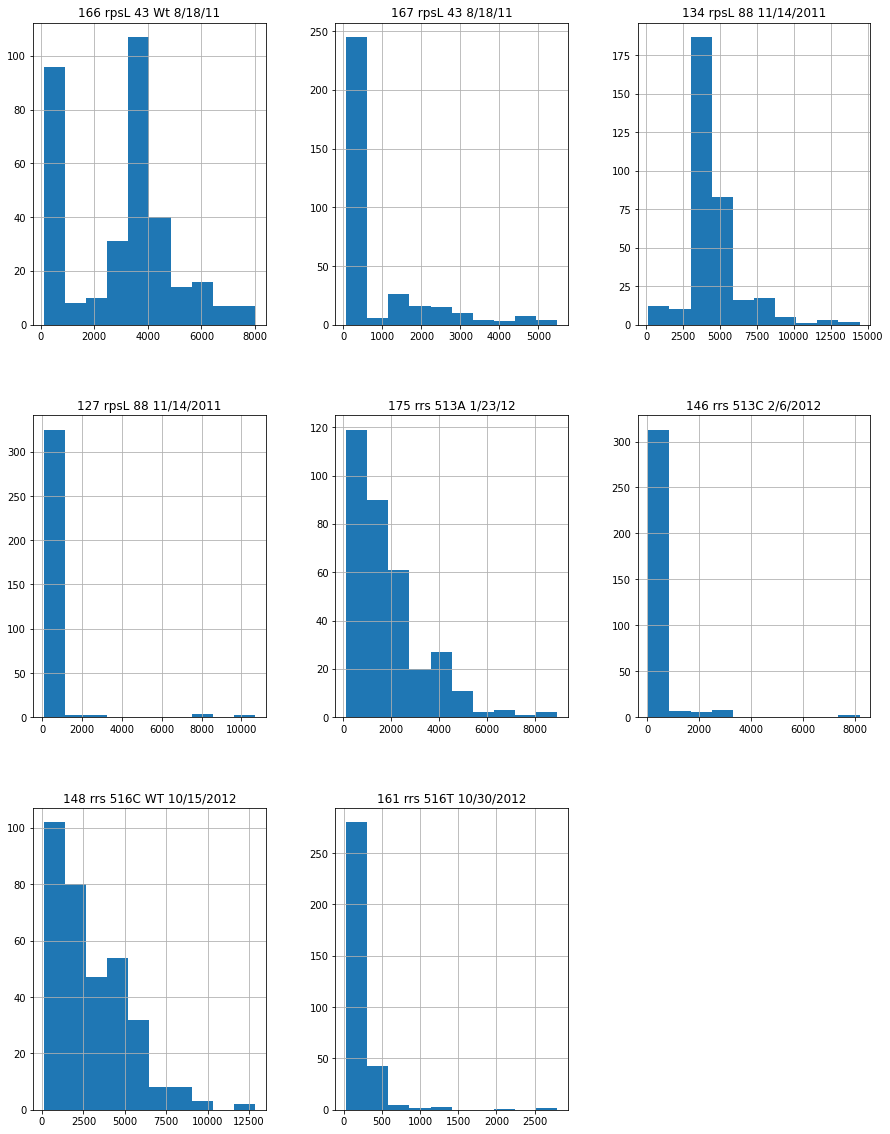

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
trimmed_sdf.hist(ax=ax)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:To output multiple subplots, the figure containing the passed axes is being cleared


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd14403f978>,
      dtype=object)

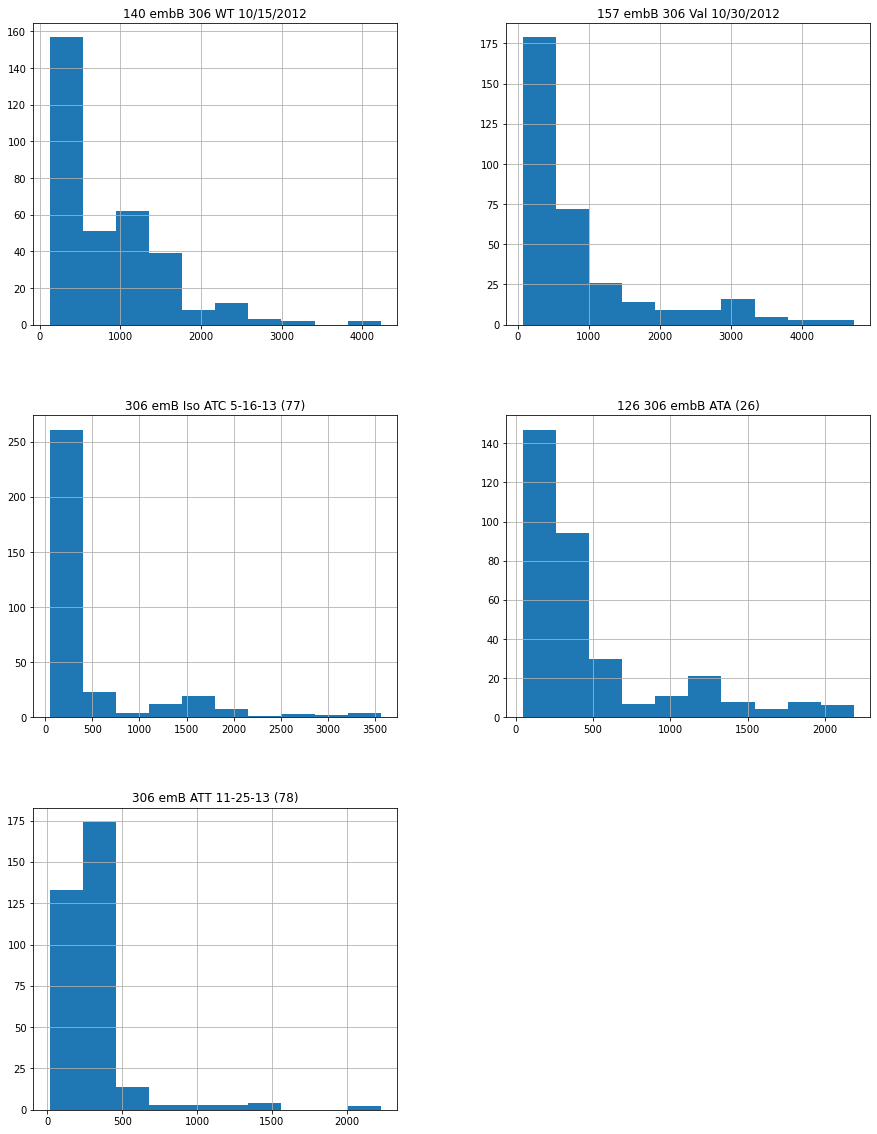

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
trimmed_edf.hist(ax=ax)

In [ ]:
import statistics

def calc_stats(value):
  results_df = pd.DataFrame(columns=['Amino Acid', 'Expressed Mean', 'Expressed Median', 'Expressed Std Dev', 'Not Expressed Mean', 'Not Expressed Median', 'Not Expressed Std Dev'])
  expressed = []
  notexpressed = []
  for i in value.columns:
    sumExpressed = 0
    countExpressed = 0
    sumNotExpressed = 0
    countNotExpressed =0
    meanExpressed = 0
    meanNotExpressed =0
    for j in value[i]:
      try:
        if (j.value[1] == True):
          expressed.append(j.value[0])
          sumExpressed=sumExpressed+ j.value[0]
          countExpressed = countExpressed + 1
        if (j.value[1] == False):
          notexpressed.append(j.value[0])
          sumNotExpressed=sumNotExpressed+j.value[0]
          countNotExpressed = countNotExpressed+1
      except:
        continue
    if (countExpressed !=0):
      meanExpressed = sumExpressed/countExpressed
    if (countNotExpressed !=0):
      meanNotExpressed = sumNotExpressed/countNotExpressed
    medianExpressed = statistics.median(expressed)
    stdevExpressed = statistics.stdev(expressed)
    medianNotExpressed = statistics.median(notexpressed)
    stdevNotExpressed = statistics.stdev(notexpressed)
    results_df = results_df.append({'Amino Acid': i, 'Expressed Mean': meanExpressed, 'Expressed Median': medianExpressed,'Expressed Std Dev':stdevExpressed,
                                    'Not Expressed Mean': meanNotExpressed, 'Not Expressed Median': medianNotExpressed, 'Not Expressed Std Dev':stdevNotExpressed}, ignore_index=True)
  return results_df

temp_idf = idf.copy()
temp_idf = temp_idf.drop(columns=[' Sample ID'])
temp_rdf = rdf.copy()
temp_rdf = temp_rdf.drop(columns=[' Sample ID'])
temp_sdf = sdf.copy()
temp_sdf = temp_sdf.drop(columns=[' Sample ID'])
temp_edf = edf.copy()
temp_edf = temp_edf.drop(columns=[' Sample ID'])
idf_stats_df = calc_stats((temp_idf))
rdf_stats_df = calc_stats(temp_rdf)
sdf_stats_df = calc_stats(temp_sdf)
edf_stats_df = calc_stats(temp_edf)

In [ ]:
print("Isoniazid")
idf_stats_df

Isoniazid


,Amino Acid,Expressed Mean,Expressed Median,Expressed Std Dev,Not Expressed Mean,Not Expressed Median,Not Expressed Std Dev
0,132 katG 315 Ser 8/10/09,4109.029412,4780.50,1824.818453,215.427239,202.00,79.323729
1,133 katG 315 Thr 8/10/09,3296.077830,3458.50,1513.343653,179.794355,185.50,96.747919
2,102 katG 315 Arg 3/25/09,3354.410000,3431.00,1425.289392,155.867133,157.00,102.602893
3,104 katG 315 ile 10/19/09,0.000000,3431.00,1425.289392,168.538690,157.00,96.289588
4,105 katG 315 Gly 10/19/09,0.000000,3431.00,1425.289392,191.129464,153.00,119.646001
5,106 katG 315 Asn 3/25/09,4101.750000,3435.50,1421.818820,237.411677,157.25,125.403381
6,315 katG Thr 5/2009 (2),2265.875000,3426.75,1419.409980,171.034639,156.00,117.264634
7,143 inhA -15C 11/1/11,3493.291118,3286.50,1287.568934,268.171875,156.00,122.373952
8,145 inhA -15T 11/1/11,4348.390625,3333.50,1300.254854,313.090461,168.00,140.006700


In [ ]:
print("Rifampicin")
rdf_stats_df

Rifampicin


,Amino Acid,Expressed Mean,Expressed Median,Expressed Std Dev,Not Expressed Mean,Not Expressed Median,Not Expressed Std Dev
0,162 rpoB 516 Asp 6//6/11,1344.036458,1155.5,822.177894,235.479167,208.75,139.097316
1,115 rpoB 516 Tyr 11/10/11,757.972222,1139.0,817.752534,136.058176,124.00,107.616020
2,118 rpoB 516 Val 6/15/09,799.704545,1081.5,812.314550,156.089172,125.00,105.910135
3,121 rpoB 516 Glu 8/18/11,650.333333,1076.5,811.325435,193.801515,135.00,120.004302
4,169 rpoB 516 Gly 9/2/11,788.625000,1076.5,810.399262,233.945783,139.25,149.677481
5,515 and 516 ATC rpoB (28),354.083333,1069.0,812.326262,123.289394,133.00,137.442332
6,515 and 516 rpoB ATT (58),619.875000,1069.0,812.142193,124.331325,128.00,127.664741
7,88 rpoB 526 His 21 bp 4/4/18,NaN,687.5,NaN,192.750000,128.00,127.564347
8,103 rpoB 526 Asp 8/18/11,NaN,3280.0,NaN,163.940810,129.00,126.310058
9,135 rpoB 526 Tyr 11/10/11,NaN,3514.0,NaN,164.167192,130.00,125.301052


In [ ]:
print("Streptomycin")
sdf_stats_df

Streptomycin


,Amino Acid,Expressed Mean,Expressed Median,Expressed Std Dev,Not Expressed Mean,Not Expressed Median,Not Expressed Std Dev
0,166 rpsL 43 Wt 8/18/11,3913.822581,3794.25,1395.175202,221.511364,202.00,94.862362
1,167 rpsL 43 8/18/11,2490.982955,3576.00,1476.525902,182.592742,168.00,92.728919
2,134 rpsL 88 11/14/2011,4643.967593,3857.50,1712.743580,201.000000,171.75,91.453455
3,127 rpsL 88 11/14/2011,4740.541667,3857.50,1788.293177,278.376543,200.00,194.548243
4,175 rrs 513A 1/23/12,1998.866129,3543.50,1952.174643,244.903846,201.00,192.030683
5,146 rrs 513C 2/6/2012,2515.729167,3515.25,1954.696346,151.761218,175.00,171.978931
6,148 rrs 516C WT 10/15/2012,3076.687879,3365.00,2013.971243,192.250000,175.00,171.516809
7,161 rrs 516T 10/30/2012,1439.750000,3359.25,2014.294336,221.081818,176.50,170.771040


In [ ]:
print("Ethambutol")
edf_stats_df

Ethambutol


,Amino Acid,Expressed Mean,Expressed Median,Expressed Std Dev,Not Expressed Mean,Not Expressed Median,Not Expressed Std Dev
0,140 embB 306 WT 10/15/2012,1423.636667,1309.25,633.513736,407.795699,396.00,140.880201
1,157 embB 306 Val 10/30/2012,2258.550000,1378.50,902.284696,484.105263,393.75,355.841589
2,306 emB Iso ATC 5-16-13 (77),1820.788462,1440.75,867.224984,235.147887,263.00,308.512433
3,126 306 embB ATA (26),1414.526786,1407.50,811.860612,287.644643,263.00,284.804355
4,306 emB ATT 11-25-13 (78),1460.950000,1405.50,802.913340,262.541411,263.00,257.173814


## *Analysis*

---

In [ ]:
'''
Input: column in the form of a pandas series (e.g. rdf.iloc[:, 3])
       Please note that since the last row of the DataFrame has an error (only has
       value and not TRUE / FALSE expression boolean), you may have to pass in 
       everything except the last column (e.g. rdf.iloc[:, 3][:-1])
Output: a DataFrame with 2 columns (value and expression)
        Note that rows with na are dropped. This is important to note when
        we compare across columns
'''
def make_df_from_col(column):
  col_data = []
  for item in column:
    # number_expression_pair = [#, TRUE] or [#, FALSE]
    number_expression_pair = item.value
    col_data.append(number_expression_pair)
  return pd.DataFrame(col_data, columns = ['value', 'expression']).dropna(axis=0) 

In [ ]:
# Example of using above function
make_df_from_col(rdf.iloc[:, 3][:-1])

,value,expression
0,200.0,False
1,135.5,False
2,229.5,False
3,211.5,False
4,114.5,False
...,...,...
330,53.5,False
331,114.0,False
332,79.0,False
333,118.0,False


In [ ]:
# Split up idf, rdf, and sdf into their specific dfs
# note that edf needs no splitting 
idf_katg = idf.iloc[:, [0] + list(range(1, 8))]
idf_inha = idf.iloc[:, [0] + list(range(8, 10))]
rdf_rpob1 = rdf.iloc[:, [0] + list(range(1, 8))]
rdf_rpob2 = rdf.iloc[:, [0] + list(range(8, 15))]
rdf_rpob3 = rdf.iloc[:, [0] + list(range(15, 19))]
sdf_rspl = sdf.iloc[:, [0] + list(range(1, 5))]
sdf_rrs = sdf.iloc[:, [0] + list(range(5, 9))]

In [ ]:
import math
from sklearn.preprocessing import minmax_scale
def TableToXAndY(Table):
  X = []
  Y = []
  # Assuming the table columns all have sample IDs as the first column
  TempTable = Table.drop(idf.columns[0],axis=1)
  for Row in range(1,TempTable.shape[0]):
    TempRow = []
    TempY = []
    SkipRow = False
    for ColumnVal in TempTable.iloc[Row]:
      if math.isnan(ColumnVal.value[0]):
        SkipRow = True
      TempRow.append(ColumnVal.value[0])
      TempY.append(int(ColumnVal.value[1]))
    if not SkipRow:
      X.append(TempRow)
      Y.append(TempY)

  return [X,Y]

In [ ]:
import random
def shuffle_cols(X, Y):
  # initialize the new X and Y matrices
  transformed_X = []
  transformed_Y = []
  for row_index in range(len(X)):
    # randomize the new indices (do i shuffle each row independent of others or do i shuffle all the same way?)
    new_indices = random.sample(list(range(len(X[0]))), k = len(X[0]))
    # save the original rows
    original_X_row = X[row_index]
    original_Y_row = Y[row_index]
    # initialize the new rows
    new_X_row = []
    new_Y_row = []
    # add to the new rows in the order specified by the new_indices list
    for new_index in new_indices:
      new_X_row.append(original_X_row[new_index])
      new_Y_row.append(original_Y_row[new_index])

    # add the new row to the transformed matrices 
    transformed_X.append(new_X_row)
    transformed_Y.append(new_Y_row)

  return [transformed_X, transformed_Y]   

### Logistic Regression

In [ ]:
def determine_expressed_cols(patient_data):
  # save all the colums in the row
  cols = []
  for container in patient_data.index.to_list():
    cols.append(container.value)

  # get the expressed columns
  expressed_cols = []
  for column_index in range(len(cols)):
    if cols[column_index] != 'Sample ID' and patient_data[column_index].value[1] == True:
      expressed_cols.append(cols[column_index])

  # return the expressed column as __ & __ ...
  return ' & '.join(expressed_cols)  

def replace_with_only_value(df_element):
  # return just the number and not the expressed value
  return df_element.value[0]
  

def reorganize_data_for_row_analysis(df):
  df_copy = df.copy()
  df_copy['Expressed'] = df_copy.apply(determine_expressed_cols, axis = 1)
  df_copy.loc[:, df_copy.columns != 'Expressed'] = df_copy.loc[:, df_copy.columns != 'Expressed'].applymap(replace_with_only_value)
  df_copy['Expressed'] = df_copy['Expressed'].astype(dtype='string')
  return df_copy

In [ ]:
dataframes_dict = {
    'idf_katg': reorganize_data_for_row_analysis(idf_katg),
    'idf_inha': reorganize_data_for_row_analysis(idf_inha),
    'rdf_rpob1': reorganize_data_for_row_analysis(rdf_rpob1),
    'rdf_rpob2': reorganize_data_for_row_analysis(rdf_rpob2),
    'rdf_rpob3': reorganize_data_for_row_analysis(rdf_rpob3),
    'sdf_rspl': reorganize_data_for_row_analysis(sdf_rspl),
    'sdf_rrs': reorganize_data_for_row_analysis(sdf_rrs),
}

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

lr_accuracy_sums = 0
lr_models_and_data_dict = {}
for drug in dataframes_dict:
  # GET THE DATAFRAME ASSOCIATED WITH THE DRUG
  current_df = dataframes_dict[drug]
  
  # DROP THE NA VALUES (VERY FEW)
  current_df = current_df.dropna(axis = 0)
  
  # GET THE X AND Y AND SPLIT DATA
  X = current_df.loc[:, (current_df.columns != 'Expressed') & (current_df.columns != ' Sample ID')]
  Y = current_df['Expressed'].copy()
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.7)

  # SCALE THE DATA
  std_scaler = StandardScaler()
  std_scaler.fit(X_train)
  X_train_transformed = std_scaler.transform(X_train)
  X_test_transformed = std_scaler.transform(X_test)

  # FIT THE MODEL
  lr_model = LogisticRegression(C = 10000, fit_intercept = True, max_iter = 1000000)
  lr_model.fit(X_train_transformed, Y_train)
  Y_pred = lr_model.predict(X_test_transformed)

  # GET THE ACCURACY SCORE
  accuracy = accuracy_score(Y_test, Y_pred)
  print('{} accuracy: {}'.format(drug, accuracy))

  # SAVE THE MODEL DATA
  lr_models_and_data_dict[drug] = {}
  lr_models_and_data_dict[drug]['model'] = lr_model
  lr_models_and_data_dict[drug]['scaler'] = std_scaler
  lr_models_and_data_dict[drug]['accuracy score'] = accuracy

  # ADD THE ACCURACY TO ACCURACY SUMS
  lr_accuracy_sums += accuracy
  
lr_average_accuracy = lr_accuracy_sums / len(dataframes_dict)
print('Average accuracy:', lr_average_accuracy)

idf_katg accuracy: 1.0
idf_inha accuracy: 1.0
rdf_rpob1 accuracy: 0.9891304347826086
rdf_rpob2 accuracy: 1.0
rdf_rpob3 accuracy: 0.9888888888888889
sdf_rspl accuracy: 1.0
sdf_rrs accuracy: 1.0
Average accuracy: 0.9968599033816424


In [ ]:
# MOCK TRIAL OF USING MODEL
# credit to https://stackoverflow.com/questions/1867861/how-to-keep-keys-values-in-same-order-as-declared
# for explaining using OrderedDict and https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
# for index explanation
from collections import OrderedDict
isoniazid_testing = dataframes_dict['idf_katg']
X = isoniazid_testing.loc[:, (isoniazid_testing.columns != 'Expressed') & (isoniazid_testing.columns != ' Sample ID')]
isoniazid_test_dict = OrderedDict()
for container in X.columns.to_list():
  isoniazid_test_dict[container.value] = X.iloc[0][container.value]

test_df = pd.DataFrame(isoniazid_test_dict, columns = isoniazid_test_dict.keys(), index = [0])
test_values_scaled = lr_models_and_data_dict['idf_katg']['scaler'].transform(test_df)
print('Prediction:', lr_models_and_data_dict['idf_katg']['model'].predict(test_values_scaled)[0])
test_df

Prediction: 133 katG 315 Thr 8/10/09


,132 katG 315 Ser 8/10/09,133 katG 315 Thr 8/10/09,102 katG 315 Arg 3/25/09,104 katG 315 ile 10/19/09,105 katG 315 Gly 10/19/09,106 katG 315 Asn 3/25/09,315 katG Thr 5/2009 (2)
0,209.0,3124.0,125.0,178.0,145.5,299.5,147.0


In [ ]:
'''

IGNORE THIS AS THIS WAS THE OLD COLUMN BY COLUMN METHOD

from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

models_and_data_dict = {}
for drug in dataframes_dict:
  print(drug)
  current_df = dataframes_dict[drug]
  for column_index in range(1, len(current_df.columns)):
    # SPLIT THE DATA
    column_df = make_df_from_col(current_df.iloc[:, column_index])
    X = column_df['value']
    Y = column_df['expression']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

    # SCALE THE DATA
    # scale the training data according to standard scaler
    # see https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
    # for why we need to call .values and then reshape into 2D array
    std_scaler = StandardScaler()
    std_scaler.fit(X_train.values.reshape(-1, 1))
    X_train_transformed = std_scaler.transform(X_train.values.reshape(-1, 1))
    X_test_transformed = std_scaler.transform(X_test.values.reshape(-1, 1))

    # PERFORM LOGISTIC REGRESSION (ONLY IF THERE ARE BOTH TRUE AND FALSE VALUES)
    if len(Y.unique()) > 1:
      lr_model = LogisticRegressionCV(fit_intercept = True)
      lr_model.fit(X_train_transformed, Y_train)
      Y_pred = lr_model.predict(X_test_transformed)

      # GET THE ACCURACY SCORE
      accuracy = accuracy_score(Y_test, Y_pred)
      print('{} accuracy: {}'.format(current_df.columns[column_index], accuracy))
'''

"\n\nIGNORE THIS AS THIS WAS THE OLD COLUMN BY COLUMN METHOD\n\nfrom sklearn.linear_model import LogisticRegressionCV\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.metrics import accuracy_score\n\nmodels_and_data_dict = {}\nfor drug in dataframes_dict:\n  print(drug)\n  current_df = dataframes_dict[drug]\n  for column_index in range(1, len(current_df.columns)):\n    # SPLIT THE DATA\n    column_df = make_df_from_col(current_df.iloc[:, column_index])\n    X = column_df['value']\n    Y = column_df['expression']\n    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)\n\n    # SCALE THE DATA\n    # scale the training data according to standard scaler\n    # see https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape\n    # for why we need to call .values and then reshape into 2D array\n    std_scaler = StandardScaler()\n    std_scaler.fit(X_train.values.reshape(-1, 1))\n    X_train_transformed = std_scale

### Decision Tree

In [ ]:
# Neccessary libraries, if you touch my code I may cry..I am warning you
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import minmax_scale

# All the sub-tables we will be analyzing
SubTables = [[idf,"idf"],[rdf,"rdf"],[sdf,"sdf"],[edf,"edf"]]
# Model storage format --> ResultStorage[Table Name][Column Name Of Said Table]
ResultStorage = {}
SumOfAccur = []
ParametersForGridSearch = {"criterion":["gini", "entropy"],
                           "splitter":["best", "random"],
                           "max_features":["auto", "sqrt", "log2",None],
                           "random_state":[21],
                           "class_weight": ["balanced",None]}
for Table in SubTables:
  Table[0] = Table[0].iloc[:,1:].dropna(axis=0)
  # Will use GridSearchCV -> exhaustive search for best hyperparameters
  for ColumnNum in range(Table[0].shape[1]):
    # Create X and Y matrices from Column table
    ColumnTable = make_df_from_col(Table[0].iloc[:,ColumnNum])
    XMatrix = minmax_scale(np.array([[Value] for Value in ColumnTable["value"]]))
    YMatrix = minmax_scale(np.array(ColumnTable["expression"].values))

    # Create training and test sets
    XTrain,XTest,YTrain,YTest = train_test_split(XMatrix,YMatrix,test_size=0.3,random_state=21)
    # Run GridSearch to find best hyperparameters and store the best model
    if not Table[1] in ResultStorage:
      ResultStorage[Table[1]] = {Table[0].columns[ColumnNum]:GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)}
    else:
      ResultStorage[Table[1]][Table[0].columns[ColumnNum]] = GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)
    
    # Evalute best model and output its accuracy
    SumOfAccur.append(accuracy_score(YTest,ResultStorage[Table[1]][Table[0].columns[ColumnNum]].predict(XTest)))
    print("Accuracy for {} is {}.".format(Table[0].columns[ColumnNum],SumOfAccur[-1]))

Accuracy for 132 katG 315 Ser 8/10/09 is 1.0.
Accuracy for 133 katG 315 Thr 8/10/09 is 0.9801980198019802.
Accuracy for 102 katG 315 Arg 3/25/09 is 1.0.
Accuracy for 104 katG 315 ile 10/19/09 is 1.0.
Accuracy for 105 katG 315 Gly 10/19/09 is 1.0.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 1 members, which is less than n_splits=5.


Accuracy for 106 katG 315 Asn 3/25/09 is 1.0.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy for 315 katG Thr 5/2009 (2) is 1.0.
Accuracy for 143 inhA -15C 11/1/11 is 0.9702970297029703.
Accuracy for 145 inhA -15T 11/1/11 is 1.0.
Accuracy for 162 rpoB 516 Asp 6//6/11 is 0.9108910891089109.
Accuracy for 115 rpoB 516 Tyr 11/10/11 is 0.9504950495049505.
Accuracy for 118 rpoB 516 Val 6/15/09 is 0.9504950495049505.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy for 121 rpoB 516 Glu 8/18/11 is 0.9702970297029703.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 2 members, which is less than n_splits=5.


Accuracy for 169 rpoB 516 Gly 9/2/11 is 0.9900990099009901.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 4 members, which is less than n_splits=5.


Accuracy for 515 and 516 ATC rpoB (28) is 0.9801980198019802.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy for 515 and 516 rpoB ATT (58) is 0.9801980198019802.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 4 members, which is less than n_splits=5.


Accuracy for 88 rpoB 526 His 21 bp 4/4/18 is 0.979381443298969.
Accuracy for 103 rpoB 526 Asp 8/18/11 is 1.0.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 3 members, which is less than n_splits=5.


Accuracy for 135 rpoB 526 Tyr 11/10/11 is 0.9896907216494846.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 1 members, which is less than n_splits=5.


Accuracy for 108 rpoB 526 Arg 8/18/11 is 1.0.
Accuracy for 164 rpoB 526 Leu 6/1/11 is 1.0.
Accuracy for 168 rpoB 526 Cys 9/2/11 is 1.0.
Accuracy for 181 rpoB 526 Pro 11/9/11 is 1.0.
Accuracy for 188 rpoB 531 ser WT 9/2/11 is 0.9595959595959596.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 2 members, which is less than n_splits=5.


Accuracy for 110 rpoB Cys  531 11/10/11 is 0.9797979797979798.
Accuracy for 130 rpoB 531 Trp 11/14/11 is 0.898989898989899.
Accuracy for 136 rpoB 531 Leu 8/18/11 is 0.9696969696969697.
Accuracy for 166 rpsL 43 Wt 8/18/11 is 0.9801980198019802.
Accuracy for 167 rpsL 43 8/18/11 is 1.0.
Accuracy for 134 rpsL 88 11/14/2011 is 1.0.
Accuracy for 127 rpsL 88 11/14/2011 is 0.9603960396039604.
Accuracy for 175 rrs 513A 1/23/12 is 0.9702970297029703.
Accuracy for 146 rrs 513C 2/6/2012 is 1.0.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 4 members, which is less than n_splits=5.


Accuracy for 148 rrs 516C WT 10/15/2012 is 0.9801980198019802.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:The least populated class in y has only 4 members, which is less than n_splits=5.


Accuracy for 161 rrs 516T 10/30/2012 is 0.9801980198019802.
Accuracy for 140 embB 306 WT 10/15/2012 is 0.9108910891089109.
Accuracy for 157 embB 306 Val 10/30/2012 is 0.8712871287128713.
Accuracy for 306 emB Iso ATC 5-16-13 (77) is 0.9900990099009901.
Accuracy for 126 306 embB ATA (26) is 0.9801980198019802.
Accuracy for 306 emB ATT 11-25-13 (78) is 1.0.


### Decision Tree New

In [ ]:
# Neccessary libraries, if you touch my code I may cry..I am warning you
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import minmax_scale

# All the sub-tables we will be analyzing
SubTables = [[idf_katg,"idf_katg"],
             [idf_inha,"idf_inha"],
             [rdf_rpob1,"rdf_rpob1"],
             [rdf_rpob2,"rdf_rpob2"],
             [rdf_rpob3,"rdf_rpob3"],
             [sdf_rspl,"sdf_rspl"],
             [sdf_rrs,"sdf_rrs"],
             [edf,"edf"]]

# Model storage format --> ResultStorage[Table Name][Column Name Of Said Table]
ResultStorage = {}
SumOfAccur = []
ParametersForGridSearch = {"criterion":["gini", "entropy"],
                           "splitter":["best", "random"],
                           "max_features":["auto", "sqrt", "log2",None],
                           "random_state":[21],
                           "class_weight": ["balanced",None]}
for Table in SubTables:
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))
  # Create training and test sets
  XTrain,XTest,YTrain,YTest = train_test_split(X,Y,test_size=0.3,random_state=21)
  # Run GridSearch to find best hyperparameters and store the best model
  ResultStorage[Table[1]] = GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)
    
  # Evalute best model and output its accuracy
  SumOfAccur.append(accuracy_score(YTest,ResultStorage[Table[1]].predict(XTest)))
  print("Accuracy for {} is {}.".format(Table[1],SumOfAccur[-1]))

Accuracy for idf_katg is 1.0.
Accuracy for idf_inha is 1.0.
Accuracy for rdf_rpob1 is 0.9603960396039604.
Accuracy for rdf_rpob2 is 1.0.
Accuracy for rdf_rpob3 is 0.9797979797979798.
Accuracy for sdf_rspl is 0.9801980198019802.
Accuracy for sdf_rrs is 0.9900990099009901.
Accuracy for edf is 1.0.


In [ ]:
# This is kinda sus -> report as suspicious to Dr.Khan and say it is probably due to a small dataset
print("Accuracy: ~",end="")
print(round((sum(SumOfAccur)/len(SumOfAccur))*100))

Accuracy: ~99.0


In [ ]:
# Test with rows with this method -> make sure variety comes see discussion and try with rows instead of columns

### Decision Tree (With Shuffling)

In [ ]:
# All the sub-tables we will be analyzing
SubTables = [[idf_katg,"idf_katg"],
             [idf_inha,"idf_inha"],
             [rdf_rpob1,"rdf_rpob1"],
             [rdf_rpob2,"rdf_rpob2"],
             [rdf_rpob3,"rdf_rpob3"],
             [sdf_rspl,"sdf_rspl"],
             [sdf_rrs,"sdf_rrs"],
             [edf,"edf"]]

# Model storage format --> ResultStorage[Table Name][Column Name Of Said Table]
ResultStorage = {}
SumOfAccur = []
ParametersForGridSearch = {"criterion":["gini", "entropy"],
                           "splitter":["best", "random"],
                           "max_features":["auto", "sqrt", "log2",None],
                           "random_state":[21],
                           "class_weight": ["balanced",None]}
for Table in SubTables:
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))

  RawTableShuffled = shuffle_cols(X, Y)
  X_shuffled = (np.array(RawTableShuffled[0]))
  Y_shuffled = (np.array(RawTableShuffled[1]))

  # Create training and test sets
  XTrain,XTest,YTrain,YTest = train_test_split(X_shuffled,Y_shuffled,test_size=0.3,random_state=21)
  # Run GridSearch to find best hyperparameters and store the best model
  ResultStorage[Table[1]] = GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)
    
  # Evalute best model and output its accuracy
  SumOfAccur.append(accuracy_score(YTest,ResultStorage[Table[1]].predict(XTest)))
  print("Accuracy for {} is {}.".format(Table[1],SumOfAccur[-1]))

Accuracy for idf_katg is 0.9900990099009901.
Accuracy for idf_inha is 0.9900990099009901.
Accuracy for rdf_rpob1 is 0.8613861386138614.
Accuracy for rdf_rpob2 is 0.9791666666666666.
Accuracy for rdf_rpob3 is 0.9393939393939394.
Accuracy for sdf_rspl is 0.9504950495049505.
Accuracy for sdf_rrs is 0.9405940594059405.
Accuracy for edf is 0.9603960396039604.


In [ ]:
print("Accuracy: ~",end="")
print(round((sum(SumOfAccur)/len(SumOfAccur))*100))

Accuracy: ~99.0


### Decision Tree with Synthetic Data

In [ ]:
import random
# Neccessary libraries, if you touch my code I may cry..I am warning you
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import minmax_scale

# All the sub-tables we will be analyzing
SubTables = [[idf_katg,"idf_katg"],
             [idf_inha,"idf_inha"],
             [rdf_rpob1,"rdf_rpob1"],
             [rdf_rpob2,"rdf_rpob2"],
             [rdf_rpob3,"rdf_rpob3"],
             [sdf_rspl,"sdf_rspl"],
             [sdf_rrs,"sdf_rrs"],
             [edf,"edf"]]

# Model storage format --> ResultStorage[Table Name][Column Name Of Said Table]
ResultStorage = {}
SumOfAccur = []
ParametersForGridSearch = {"criterion":["gini", "entropy"],
                           "splitter":["best", "random"],
                           "max_features":["auto", "sqrt", "log2",None],
                           "random_state":[21],
                           "class_weight": ["balanced",None]}
for Table in SubTables:
  RandomRowAdds = 1000
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))

  while RandomRowAdds > 0:
    RandomRowAdds -= 1
    IndexOfRandomLine = random.randint(0,X.shape[0]-1)
    NewLine = np.array([[Num+np.random.normal(0,1,1)[0] for Num in X[IndexOfRandomLine]]])
    
    X = np.concatenate((X,NewLine),axis=0)
    Y = np.concatenate((Y,np.array([Y[IndexOfRandomLine]])),axis=0)

  # Create training and test sets
  XTrain,XTest,YTrain,YTest = train_test_split(X,Y,test_size=0.3,random_state=21)
  # Run GridSearch to find best hyperparameters and store the best model
  ResultStorage[Table[1]] = GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)
    
  # Evalute best model and output its accuracy
  SumOfAccur.append(accuracy_score(YTest,ResultStorage[Table[1]].predict(XTest)))
  print("Accuracy for {} is {}.".format(Table[1],SumOfAccur[-1]))

Accuracy for idf_katg is 1.0.
Accuracy for idf_inha is 1.0.
Accuracy for rdf_rpob1 is 0.9975062344139651.
Accuracy for rdf_rpob2 is 0.9974747474747475.
Accuracy for rdf_rpob3 is 1.0.
Accuracy for sdf_rspl is 1.0.
Accuracy for sdf_rrs is 0.9975062344139651.
Accuracy for edf is 1.0.


In [ ]:
print("Accuracy: ~",end="")
print(round((sum(SumOfAccur)/len(SumOfAccur))*100))

Accuracy: ~100.0


### Decision Tree (with Synthetic Data and Shuffling)

In [ ]:
import random
# Neccessary libraries, if you touch my code I may cry..I am warning you
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import minmax_scale

# All the sub-tables we will be analyzing
SubTables = [[idf_katg,"idf_katg"],
             [idf_inha,"idf_inha"],
             [rdf_rpob1,"rdf_rpob1"],
             [rdf_rpob2,"rdf_rpob2"],
             [rdf_rpob3,"rdf_rpob3"],
             [sdf_rspl,"sdf_rspl"],
             [sdf_rrs,"sdf_rrs"],
             [edf,"edf"]]

# Model storage format --> ResultStorage[Table Name][Column Name Of Said Table]
ResultStorage = {}
SumOfAccur = []
ParametersForGridSearch = {"criterion":["gini", "entropy"],
                           "splitter":["best", "random"],
                           "max_features":["auto", "sqrt", "log2",None],
                           "random_state":[21],
                           "class_weight": ["balanced",None]}
for Table in SubTables:
  RandomRowAdds = 1000
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))
  while RandomRowAdds > 0:
    RandomRowAdds -= 1
    IndexOfRandomLine = random.randint(0,X.shape[0]-1)
    NewLine = np.array([[Num+np.random.normal(0,1,1)[0] for Num in X[IndexOfRandomLine]]])
    
    X = np.concatenate((X,NewLine),axis=0)
    Y = np.concatenate((Y,np.array([Y[IndexOfRandomLine]])),axis=0)

  # Shuffle the cols after adding the synthetic data 
  RawTableShuffled = shuffle_cols(X, Y)
  X_shuffled = (np.array(RawTableShuffled[0]))
  Y_shuffled = (np.array(RawTableShuffled[1]))  

  # Create training and test sets
  XTrain,XTest,YTrain,YTest = train_test_split(X_shuffled,Y_shuffled,test_size=0.3,random_state=21)
  # Run GridSearch to find best hyperparameters and store the best model
  ResultStorage[Table[1]] = GridSearchCV(DecisionTreeClassifier(),ParametersForGridSearch,scoring="accuracy").fit(XTrain,YTrain)
    
  # Evalute best model and output its accuracy
  SumOfAccur.append(accuracy_score(YTest,ResultStorage[Table[1]].predict(XTest)))
  print("Accuracy for {} is {}.".format(Table[1],SumOfAccur[-1]))

Accuracy for idf_katg is 0.9850374064837906.
Accuracy for idf_inha is 1.0.
Accuracy for rdf_rpob1 is 0.9800498753117207.
Accuracy for rdf_rpob2 is 0.9671717171717171.
Accuracy for rdf_rpob3 is 0.9874686716791979.
Accuracy for sdf_rspl is 0.9825436408977556.
Accuracy for sdf_rrs is 0.9551122194513716.
Accuracy for edf is 0.9551122194513716.


In [ ]:
print("Accuracy: ~",end="")
print(round((sum(SumOfAccur)/len(SumOfAccur))*100))

Accuracy: ~98.0


### Neural Network

In [ ]:
! pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=745ca9ff77971874b456f5a9f3fb20d106f995ff72eadc22ee4d3f9147f490a7
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=a2deee158248b9f15a876714279780544c5877bf8d599bad068e51627259aff1
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from kerastuner.tuners import RandomSearch
from sklearn.metrics import accuracy_score
# Resources Used
# ECS 171 Discussion-10-30 [ECS 171 Fall 2020]
# https://keras-team.github.io/keras-tuner/
# https://machinelearningmastery.com/multi-label-classification-with-deep-learning/


SubTables = [[idf_katg,"idf_katg"],
             [idf_inha,"idf_inha"],
             [rdf_rpob1,"rdf_rpob1"],
             [rdf_rpob2,"rdf_rpob2"],
             [rdf_rpob3,"rdf_rpob3"],
             [sdf_rspl,"sdf_rspl"],
             [sdf_rrs,"sdf_rrs"],
             [edf,"edf"]]
Models = {}
MeanAccuracy = 0

for Table in SubTables:
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))
  XTrain,XTestVal,YTrain,YTestVal = train_test_split(X,Y,test_size=0.3,random_state=21)
  XTest,XVal,YTest,YVal = train_test_split(XTestVal,YTestVal,test_size=0.5,random_state=21)
  NeuralNet = Sequential()
  NeuralNet.add(Dense(27,activation="relu",input_dim=X.shape[1]))
  NeuralNet.add(Dense(27,activation="relu"))
  NeuralNet.add(Dense(Y.shape[1],activation="sigmoid"))
  NeuralNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  NeuralNet.fit(XTrain, YTrain,batch_size=10, epochs=45,validation_data=(XVal, YVal),verbose=0)
  Models[Table[1]] = NeuralNet
  Result = NeuralNet.predict(XTest).round()
  Accuracy = accuracy_score(YTest,Result)
  MeanAccuracy += Accuracy
  print("{} Accuracy: {}".format(Table[1],Accuracy))

idf_katg Accuracy: 0.98
idf_inha Accuracy: 0.98
rdf_rpob1 Accuracy: 0.96
rdf_rpob2 Accuracy: 1.0
rdf_rpob3 Accuracy: 0.9591836734693877
sdf_rspl Accuracy: 1.0
sdf_rrs Accuracy: 1.0
edf Accuracy: 0.96


In [ ]:
print(MeanAccuracy/8)

0.9798979591836735


In [ ]:
# Shows that we can us saved models for prediction purposes
RawTable = TableToXAndY(idf_inha)
Models['idf_inha'].predict(np.array(RawTable[0])[:1])

array([[1., 0.]], dtype=float32)

### Neural Net (Optimized)

In [ ]:

from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# https://www.machinecurve.com/index.php/2020/06/09/automating-neural-network-configuration-with-keras-tuner/
# https://github.com/keras-team/keras-tuner
InputShape = 0
OutputShape = 0
def Model(HP):
  print(InputShape)
  NeuralNet = Sequential()
  NeuralNet.add(Dense(units=HP.Int('units',min_value=25,max_value=35,step=5),activation="relu",input_dim=InputShape))
  NeuralNet.add(Dense(units=HP.Int('units',min_value=25,max_value=35,step=5),activation="relu"))
  NeuralNet.add(Dense(OutputShape,activation="sigmoid"))
  NeuralNet.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])
  return NeuralNet


ModelOpt = {}
ResultDict = {}
for Table in SubTables:
  RawTable = TableToXAndY(Table[0])
  X = (np.array(RawTable[0]))
  Y = (np.array(RawTable[1]))
  InputShape = X.shape[1]
  OutputShape = Y.shape[1]
  XTrain,XTest,YTrain,YTest = train_test_split(X,Y,test_size=0.3,random_state=21)
  Tuner = RandomSearch(
      Model,
      objective='val_accuracy',
      max_trials=3,
      executions_per_trial=5,
      directory='Tuning_dir',
      project_name='NN_Result_Temp'+Table[1])

  Result = Tuner.search(XTrain, YTrain,
              epochs=10,
              validation_split=0.3)
  ModelOpt[Table[1]] = Tuner.get_best_models(num_models=1)[0]
  ModelOpt[Table[1]].fit(XTrain, YTrain,batch_size=15, epochs=40,verbose=0)
  Score = ModelOpt[Table[1]].evaluate(XTest, YTest, verbose=0)
  ResultDict[Table[1]] = round(Score[1],2)

Trial 2 Complete [00h 00m 06s]
val_accuracy: 0.8985915422439575

Best val_accuracy So Far: 0.9211267590522766
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit
5


In [ ]:
ResultL = 0
for Result in ResultDict:
  print("{} Accuracy: {}".format(Result,ResultDict[Result]))
  ResultL += ResultDict[Result]

print(ResultL/8)

idf_katg Accuracy: 0.99
idf_inha Accuracy: 1.0
rdf_rpob1 Accuracy: 1.0
rdf_rpob2 Accuracy: 0.99
rdf_rpob3 Accuracy: 0.97
sdf_rspl Accuracy: 0.43
sdf_rrs Accuracy: 0.12
edf Accuracy: 1.0
0.8125


### Z Scores

In [ ]:
# z scores by column
import scipy.stats as stats

# put dataframes into arrays, ex: idf_table[0]['value'] is the first column's values
# split into subtables 

idf_table = []
for i in range(1,len(idf.columns)):
  idf_table.append(make_df_from_col(idf.iloc[:,i]))

katG_table = idf_table[0:7]
inhA_table = idf_table[7:]

rdf_table = []
for i in range(1,len(rdf.columns)):
  rdf_table.append(make_df_from_col(rdf.iloc[:,i]))

rdf_516_table = rdf_table[0:7]
rdf_526_table = rdf_table[7:14]
rdf_531_table = rdf_table[14:]

sdf_table = []
for i in range(1,len(sdf.columns)):
  sdf_table.append(make_df_from_col(sdf.iloc[:,i]))

sdf_rpsL_table = sdf_table[0:4]
sdf_rrs_table = sdf_table[4:]

edf_table = []
for i in range(1,len(edf.columns)):
  edf_table.append(make_df_from_col(edf.iloc[:,i]))

# put those tables into an array to index them
# ie: tables[0][0]['value'] would give the first column of the first table's values

tables = [katG_table, inhA_table, rdf_516_table,rdf_526_table, rdf_531_table, sdf_rpsL_table, sdf_rrs_table, edf_table]

# add a column to each row to hold its zscores
for i in range(len(tables)):
  for j in range(len(tables[i])):
    zscores = tables[i][j].apply(stats.zscore)
    tables[i][j]['z_scores'] = zscores['value']
    tables[i][j]['test_expression'] = False

# compares the zscores in each row and find the max value
for i in range(len(tables)):
  for j in range(tables[i][0].count()[0]): # num rows
    max = tables[i][0].iloc[j]['z_scores']
    cur_expressed = 0
    for k in range(len(tables[i])): # num cols
      cur_z = tables[i][k].iloc[j]['z_scores']
      if cur_z > max:
        max = cur_z
        cur_expressed = k 
    tables[i][cur_expressed]['test_expression'].iloc[j] = True

for i in range(5,7):
  for j in range(tables[i][0].count()[0]): # num rows
    if tables[i][cur_expressed]['test_expression'].iloc[j] == False:
      max = tables[i][0].iloc[j]['z_scores']
      cur_expressed = 0
    else:
      max = tables[i][1].iloc[j]['z_scores']
      cur_expressed = 1
    for k in range(len(tables[i])): # num cols
      if tables[i][k]['test_expression'].iloc[j] == False:
        cur_z = tables[i][k].iloc[j]['z_scores']
        if cur_z > max:
          max = cur_z
          cur_expressed = k 
    tables[i][cur_expressed]['test_expression'].iloc[j] = True

zscore_accuracy = []
# get accuracy of each table
for i in range(len(tables)):
  avg_accuracy = 0
  for j in range(len(tables[i])): # num cols
    avg_accuracy = avg_accuracy + accuracy_score(tables[i][j]['expression'], tables[i][j]['test_expression'])
  zscore_accuracy.append(avg_accuracy/len(tables[i]))
  
zscore_accuracy


In [ ]:
# z scores by subtable
import scipy.stats as stats

# put dataframes into arrays, ex: idf_table[0]['value'] is the first column's values
# split into subtables 

idf_table = []
for i in range(1,len(idf.columns)):
  idf_table.append(make_df_from_col(idf.iloc[:,i]))

katG_table = idf_table[0:7]
inhA_table = idf_table[7:]

rdf_table = []
for i in range(1,len(rdf.columns)):
  rdf_table.append(make_df_from_col(rdf.iloc[:,i]))

rdf_516_table = rdf_table[0:7]
rdf_526_table = rdf_table[7:14]
rdf_531_table = rdf_table[14:]

sdf_table = []
for i in range(1,len(sdf.columns)):
  sdf_table.append(make_df_from_col(sdf.iloc[:,i]))

sdf_rpsL_table = sdf_table[0:4]
sdf_rrs_table = sdf_table[4:]

edf_table = []
for i in range(1,len(edf.columns)):
  edf_table.append(make_df_from_col(edf.iloc[:,i]))

# put those tables into an array to index them
# ie: tables[0][0]['value'] would give the first column of the first table's values

tables = [katG_table, inhA_table, rdf_516_table,rdf_526_table, rdf_531_table, sdf_rpsL_table, sdf_rrs_table, edf_table]

def get_zscore(table):
  values_mat = []
  for i in range(len(table)):
    for j in range(len(table[i]['value'])):
      values_mat.append(table[i]['value'].iloc[j])
  return stats.zscore(values_mat)


# add a column to each row to hold its zscores
for i in range(len(tables)):
  zscores = get_zscore(tables[i])
  count = 0
  for j in range(len(tables[i])):
    tables[i][j]['z_scores'] = zscores[count]
    tables[i][j]['test_expression'] = False
    count = count + 0

# compares the zscores in each row and find the max value
for i in range(len(tables)):
  for j in range(tables[i][0].count()[0]): # num rows
    max = tables[i][0].iloc[j]['z_scores']
    cur_expressed = 0
    for k in range(len(tables[i])): # num cols
      cur_z = tables[i][k].iloc[j]['z_scores']
      if cur_z > max:
        max = cur_z
        cur_expressed = k 
    tables[i][cur_expressed]['test_expression'].iloc[j] = True

for i in range(5,7):
  for j in range(tables[i][0].count()[0]): # num rows
    if tables[i][cur_expressed]['test_expression'].iloc[j] == False:
      max = tables[i][0].iloc[j]['z_scores']
      cur_expressed = 0
    else:
      max = tables[i][1].iloc[j]['z_scores']
      cur_expressed = 1
    for k in range(len(tables[i])): # num cols
      if tables[i][k]['test_expression'].iloc[j] == False:
        cur_z = tables[i][k].iloc[j]['z_scores']
        if cur_z > max:
          max = cur_z
          cur_expressed = k 
    tables[i][cur_expressed]['test_expression'].iloc[j] = True

zscore_accuracy = []
# get accuracy of each table
for i in range(len(tables)):
  avg_accuracy = 0
  for j in range(len(tables[i])): # num cols
    avg_accuracy = avg_accuracy + accuracy_score(tables[i][j]['expression'], tables[i][j]['test_expression'])
  zscore_accuracy.append(avg_accuracy/len(tables[i]))
  
zscore_accuracy
